In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from IPython.display import display
import scikit_posthocs as sp

In [5]:
df = pd.read_csv("Pairwise Cluster Comparisons - FINAL.txt", sep="\t")

In [6]:
def pval_to_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

In [7]:
families_of_interest = ["Family_1_6", "Family_1_7", "Family_1_8"]
df_1x = df[df[families_of_interest].eq("Yes").any(axis=1)].copy()

In [8]:
# Define first base groups
for base in ["A", "U", "C", "G"]:
    df_1x[f"{base}_First"] = np.where(
        (df_1x["FirstBase1"] == base) & (df_1x["FirstBase2"] == base),
        f"{base}-in-First", f"Not-{base}"
    )

In [13]:
# Turn into long format
records = []
for col in families_of_interest:
    fam_df = df_1x[df_1x[col] == "Yes"].copy()
    fam_df["Family"] = col.replace("Family_", "HRC") # replace Family with Homology Region Class (HRC)
    records.append(fam_df)

plot_df = pd.concat(records, ignore_index=True)

In [15]:
base_palettes = {
    "A": {
        f"A-in-First": "#78e3c1",     
        f"Not-A": "#56a38a"           
    },
    "U": {
        f"U-in-First": "#f6c1c1",     
        f"Not-U": "#c97b7b"           
    },
    "C": {
        f"C-in-First": "#c1d6f6",     
        f"Not-C": "#5b86c9"           
    },
    "G": {
        f"G-in-First": "#fce5b4",     
        f"Not-G": "#c99c4d"          
    }
}

Save plot for A? (yes/no):  yes


Saved as jaccard_violinplot_firstbase_A.png


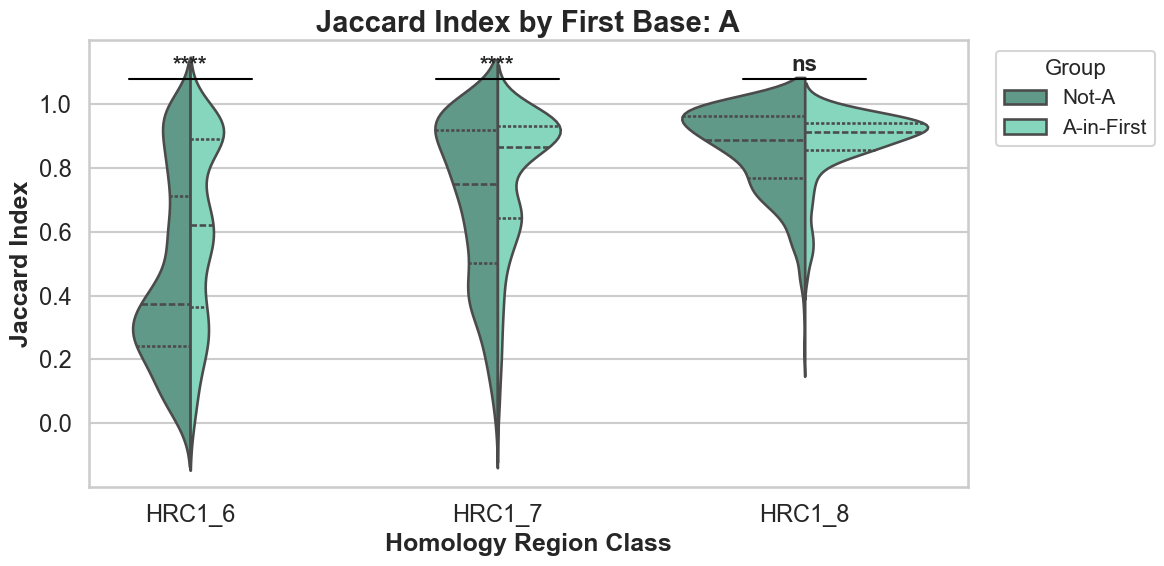

Save plot for U? (yes/no):  yes


Saved as jaccard_violinplot_firstbase_U.png


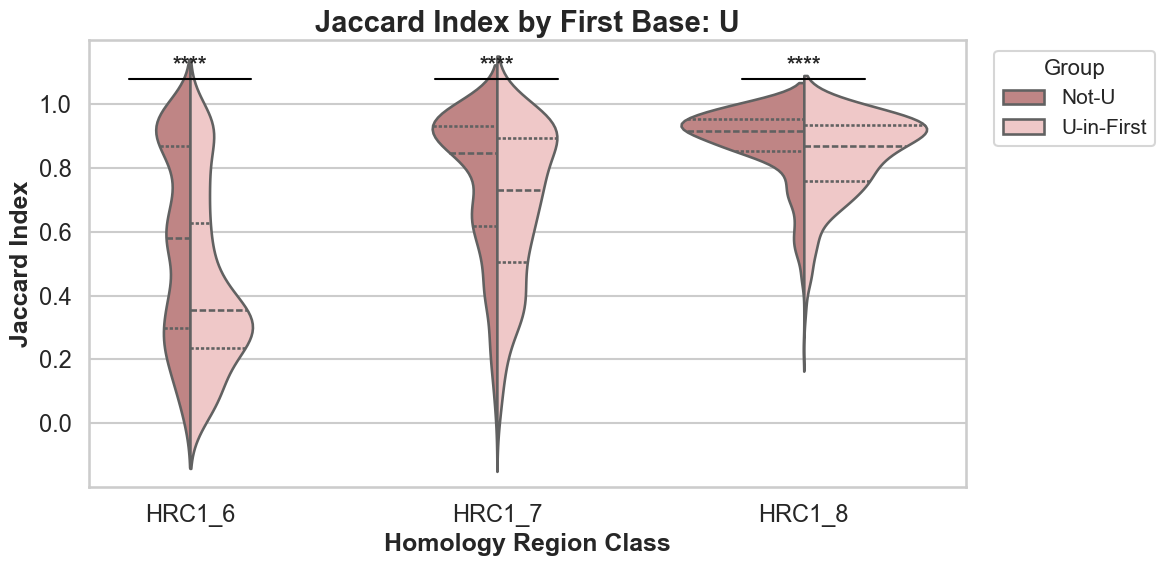

Save plot for C? (yes/no):  yes


Saved as jaccard_violinplot_firstbase_C.png


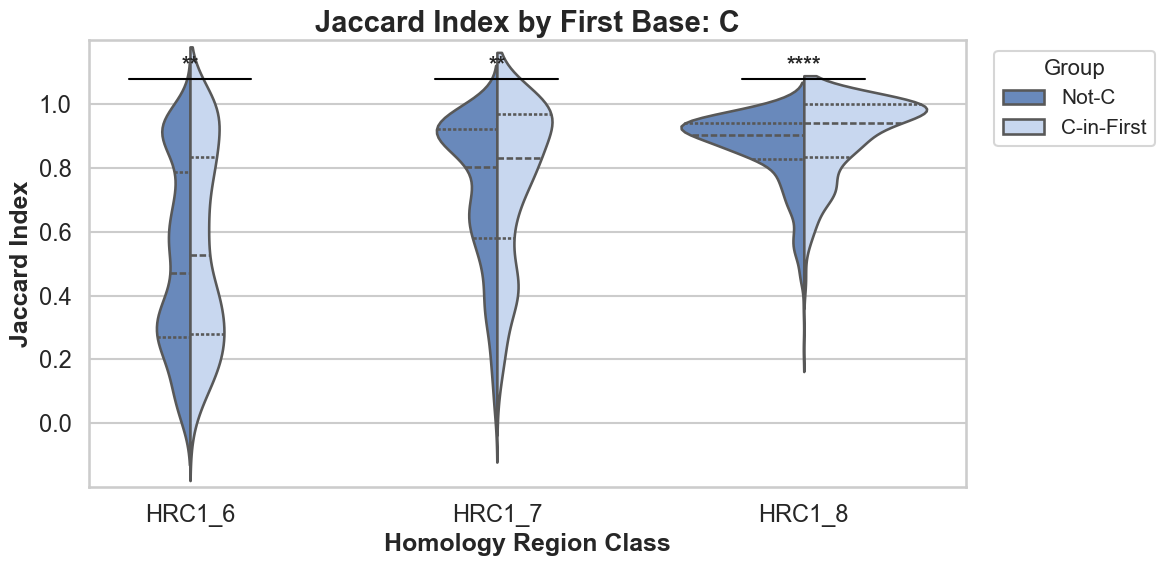

Save plot for G? (yes/no):  yes


Saved as jaccard_violinplot_firstbase_G.png


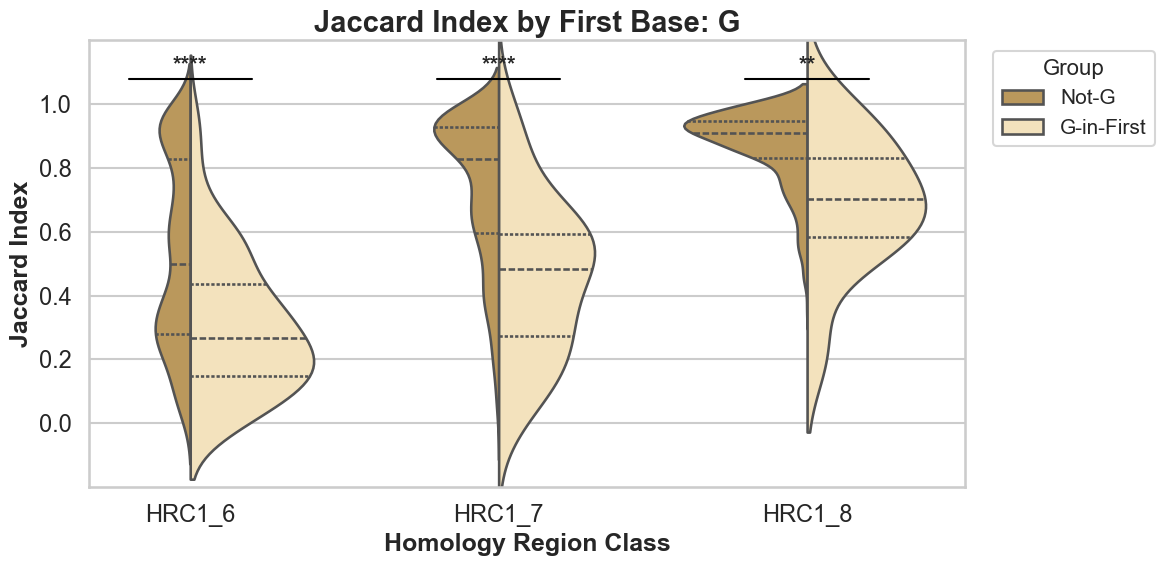

In [19]:
# Plot for each base
test_results = []

for base in ["A", "U", "C", "G"]:
    group_col = f"{base}_First"
    sub_df = plot_df.copy()
    sub_df["Group"] = sub_df[group_col]
    sub_df = sub_df[sub_df["Group"].isin([f"{base}-in-First", f"Not-{base}"])]

    sns.set(style="whitegrid", context="talk")
    palette_dict = base_palettes[base]
    hue_order = [f"Not-{base}", f"{base}-in-First"]

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(
        data=sub_df,
        x="Family",
        y="Jaccard",
        hue="Group",
        split=True,
        inner="quartile",
        palette=palette_dict,
        hue_order=hue_order
    )

    families = ["HRC1_6", "HRC1_7", "HRC1_8"]
    for i, fam in enumerate(families):
        fam_df = sub_df[sub_df["Family"] == fam]
        g1 = fam_df[fam_df["Group"] == f"{base}-in-First"]["Jaccard"]
        g2 = fam_df[fam_df["Group"] == f"Not-{base}"]["Jaccard"]

        if len(g1) == 0 or len(g2) == 0:
            continue

        stat, p_value = mannwhitneyu(g1, g2, alternative="two-sided")
        stars = pval_to_stars(p_value)

        test_results.append({
            "Family": fam,
            "n Base-in-First": len(g1),
            "n Not-Base": len(g2),
            "Median Base": g1.median(),
            "Median Not": g2.median(),
            "p-value": p_value,
            "Significance": stars
        })

        y_max = sub_df["Jaccard"].max() + 0.08
        x1, x2 = i - 0.2, i + 0.2
        plt.plot([x1, x2], [y_max, y_max], color='black', linewidth=1.5)
        plt.text((x1 + x2) / 2, y_max + 0.01, stars, ha='center', va='bottom', fontsize=16, fontweight="bold")

    plt.title(f"Jaccard Index by First Base: {base}", fontsize=21, fontweight="bold")
    plt.ylabel("Jaccard Index", fontsize=18, fontweight="bold")
    plt.xlabel("Homology Region Class", fontsize=18, fontweight="bold")
    plt.xticks(fontsize=17)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=17)
    plt.ylim(-0.2, 1.2)
    plt.legend(title="Group", title_fontsize=16, fontsize=15, loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()

    save = input(f"Save plot for {base}? (yes/no): ").strip().lower()
    if save == 'yes':
        filename = f"jaccard_violinplot_firstbase_{base}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved as {filename}")

    plt.show()

In [19]:
results = []

for base in ["A", "U", "C", "G"]:
    group_col = f"{base}_First"
    sub_df = plot_df.copy()
    sub_df["Group"] = sub_df[group_col]
    sub_df = sub_df[sub_df["Group"].isin([f"{base}-in-First", f"Not-{base}"])]

    for fam in ["HRC1_6", "HRC1_7", "HRC1_8"]:
        fam_df = sub_df[sub_df["Family"] == fam]
        g1 = fam_df[fam_df["Group"] == f"{base}-in-First"]["Jaccard"]
        g2 = fam_df[fam_df["Group"] == f"Not-{base}"]["Jaccard"]

        if len(g1) == 0 or len(g2) == 0:
            continue

        stat, p = mannwhitneyu(g1, g2, alternative="two-sided")

        results.append({
            "Base": base,
            "Family": fam,
            f"n {base}-in-First": len(g1),
            f"n Not-{base}": len(g2),
            f"Median {base}-in-First": g1.median(),
            f"Median Not-{base}": g2.median(),
            "U statistic": stat,
            "p-value": p
        })

results_df = pd.DataFrame(results)

display(results_df.round(4))

,Base,Family,n A-in-First,n Not-A,Median A-in-First,Median Not-A,U statistic,p-value,n U-in-First,n Not-U,Median U-in-First,Median Not-U,n C-in-First,n Not-C,Median C-in-First,Median Not-C,n G-in-First,n Not-G,Median G-in-First,Median Not-G
0,A,HRC1_6,848.0,1399.0,0.6225,0.3750,760984.0,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,HRC1_7,504.0,602.0,0.8667,0.7511,175440.0,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,HRC1_8,352.0,351.0,0.9136,0.8879,64656.5,0.2845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U,HRC1_6,NaN,NaN,NaN,NaN,436027.5,0.0000,852.0,1395.0,0.3547,0.5814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U,HRC1_7,NaN,NaN,NaN,NaN,103276.5,0.0000,329.0,777.0,0.7305,0.8482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,U,HRC1_8,NaN,NaN,NaN,NaN,37932.5,0.0000,195.0,508.0,0.8689,0.9144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,C,HRC1_6,NaN,NaN,NaN,NaN,439092.0,0.0040,NaN,NaN,NaN,NaN,449.0,1798.0,0.5285,0.4715,NaN,NaN,NaN,NaN
7,C,HRC1_7,NaN,NaN,NaN,NaN,115209.5,0.0063,NaN,NaN,NaN,NaN,238.0,868.0,0.8319,0.8027,NaN,NaN,NaN,NaN
8,C,HRC1_8,NaN,NaN,NaN,NaN,51343.0,0.0000,NaN,NaN,NaN,NaN,145.0,558.0,0.9394,0.9022,NaN,NaN,NaN,NaN
9,G,HRC1_6,NaN,NaN,NaN,NaN,60294.5,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,2149.0,0.2679,0.5000


C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn_results.applymap(pval_to_stars)
C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dunn_scores = dunn_stars.replace(star_to_score)


Save heatmap for HRC1_6? (yes/no):  yes


Plot saved as Heatmap_Dunn_HRC1_6.png


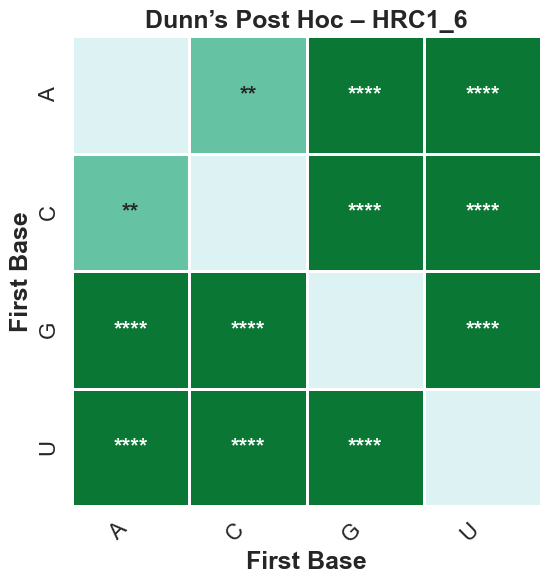

C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn_results.applymap(pval_to_stars)
C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dunn_scores = dunn_stars.replace(star_to_score)


Save heatmap for HRC1_7? (yes/no):  yes


Plot saved as Heatmap_Dunn_HRC1_7.png


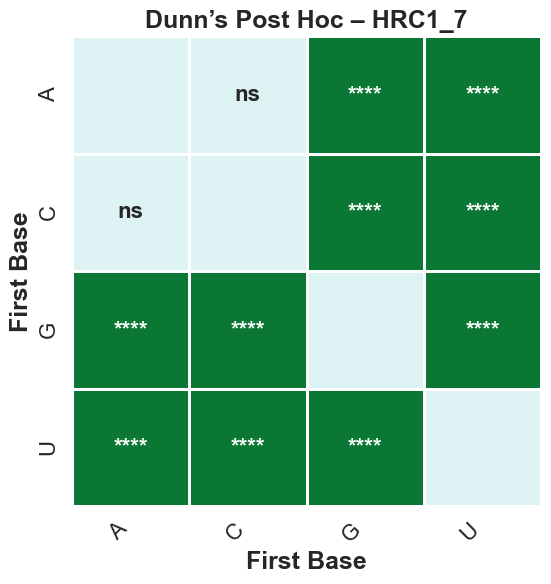

C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn_results.applymap(pval_to_stars)
C:\Users\moris\AppData\Local\Temp\ipykernel_17636\3784852264.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dunn_scores = dunn_stars.replace(star_to_score)


Save heatmap for HRC1_8? (yes/no):  yes


Plot saved as Heatmap_Dunn_HRC1_8.png


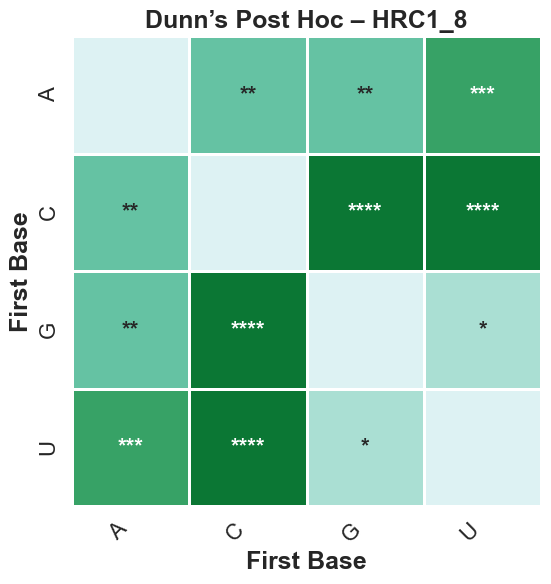

In [23]:
# Dunn's post-hoc test Heatmap - comparison between bases for each seed family
star_to_score = {"ns": 0, "*": 1, "**": 2, "***": 3, "****": 4}
pastel_green = sns.color_palette("BuGn", n_colors=5)

for fam in families:
    fam_df_dunn = plot_df[plot_df["Family"] == fam].copy()
    fam_df_dunn = fam_df_dunn[fam_df_dunn["FirstBase1"] == fam_df_dunn["FirstBase2"]].copy()
    fam_df_dunn["BaseGroup"] = fam_df_dunn["FirstBase1"]

    if fam_df_dunn["BaseGroup"].nunique() < 2:
        continue

    # Run Dunn's test - FDR corrected
    dunn_results = sp.posthoc_dunn(
        fam_df_dunn,
        val_col="Jaccard",
        group_col="BaseGroup",
        p_adjust="fdr_bh"
    )

    dunn_stars = dunn_results.applymap(pval_to_stars)

    dunn_scores = dunn_stars.replace(star_to_score)

    annot_display = dunn_stars.copy()
    for i in annot_display.index:
        annot_display.loc[i, i] = ""

    plt.figure(figsize=(8, 6))
    sns.set(style="white")
    sns.heatmap(
        dunn_scores,
        annot=annot_display,
        fmt='',
        cmap=pastel_green,
        linewidths=1,
        linecolor='white',
        square=True,
        cbar=False,
        annot_kws={"fontsize": 16, "weight": "bold"}
    )

    plt.title(f"Dunn’s Post Hoc – {fam}", fontsize=18, fontweight='bold')
    plt.xlabel("First Base", fontsize=18, fontweight='bold')
    plt.ylabel("First Base", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.yticks(fontsize=16)
    plt.tight_layout()

    save = input(f"Save heatmap for {fam}? (yes/no): ").strip().lower()
    if save == 'yes':
        plt.savefig(f"Heatmap_Dunn_{fam}.png", dpi=300, bbox_inches='tight')
        print(f"Plot saved as Heatmap_Dunn_{fam}.png")

    plt.show()